# Relative Drug Bandit
### Hannah/Patrick/John

Possible aims for a bandit:
    - to minimize the uncertainty of the overall map
    - to prioritise simulating the highest affinity ligands
    - rank order the ligands as rapidly as possible
    
Two things that can be treated as an arm
    - an edge (A - B), containing a combination of all mappings (and possibly combinations of edges A - C - B)
    - all possible edges (intra-edge)
    
   

Here: optimising rank-ordering ligands, assuming there is one mapping per edge

In [40]:
from drugbandit import bandit, pull, choose
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import random
import itertools
from copy import deepcopy
# from random import randint

%matplotlib inline

In [2]:
def plotbanditsvsexperiment(bandits):
    '''
    Plots the Bandit's expected free energy and error against the experimental free energy and error
    '''
    experimental = [arm.fe for arm in bandits]
    experimental_error = [arm.error for arm in bandits]

    calculated = [arm.nu for arm in bandits]
    calculated_error = [arm.sigma for arm in bandits]

    plt.errorbar(experimental,calculated,xerr=experimental_error,yerr=calculated_error,fmt='o',ms=0,color='k',alpha=0.3)
    plt.scatter(experimental,calculated)
    plt.plot(experimental,experimental,color='b',alpha=0.2)
    plt.xlabel('Experimental / kcal mol$^{-1}$')
    plt.ylabel('Calculated / kcal mol$^{-1}$')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

In [3]:
ligands = []

with open('set_of_eight.smiles','r') as f:
    index = 0
    for line in f:
        if line[0] != '#':
            details = line.split(';')
            ligands.append([details[2], float(details[3]), float(details[4])])

index = 0
rel_bandits = []
for lig_a, lig_b in itertools.combinations(ligands,2):  # generating all edges
#    name, exp_fe, exp_error
    rel_name = lig_a[0]+'-'+lig_b[0]
    rel_fe = lig_a[1] - lig_b[1]
    rel_error = np.sqrt(lig_a[2]**2 + lig_b[2]**2)
#     print(rel_name,rel_fe,rel_error)
    rel_bandits.append(bandit.Bandit(rel_name,rel_fe,rel_error,index))
    index+=1
    
    
for band in rel_bandits:
    print(band.name)

benzene-phenol
benzene-toluene
benzene-trifluoromethylbenzene
benzene-1,2-bis(trifluoromethyl)benzene
benzene-chlorobenzene
benzene-2-chlorophenol
benzene-benzenethiol
phenol-toluene
phenol-trifluoromethylbenzene
phenol-1,2-bis(trifluoromethyl)benzene
phenol-chlorobenzene
phenol-2-chlorophenol
phenol-benzenethiol
toluene-trifluoromethylbenzene
toluene-1,2-bis(trifluoromethyl)benzene
toluene-chlorobenzene
toluene-2-chlorophenol
toluene-benzenethiol
trifluoromethylbenzene-1,2-bis(trifluoromethyl)benzene
trifluoromethylbenzene-chlorobenzene
trifluoromethylbenzene-2-chlorophenol
trifluoromethylbenzene-benzenethiol
1,2-bis(trifluoromethyl)benzene-chlorobenzene
1,2-bis(trifluoromethyl)benzene-2-chlorophenol
1,2-bis(trifluoromethyl)benzene-benzenethiol
chlorobenzene-2-chlorophenol
chlorobenzene-benzenethiol
2-chlorophenol-benzenethiol


Step 250


/Users/brucemah/miniconda3/lib/python3.6/site-packages/drugbandit-0.0.0+4.gdfdda1b.dirty-py3.6.egg/drugbandit/bandit.py:138: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/brucemah/miniconda3/lib/python3.6/site-packages/drugbandit-0.0.0+4.gdfdda1b.dirty-py3.6.egg/drugbandit/bandit.py:142: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


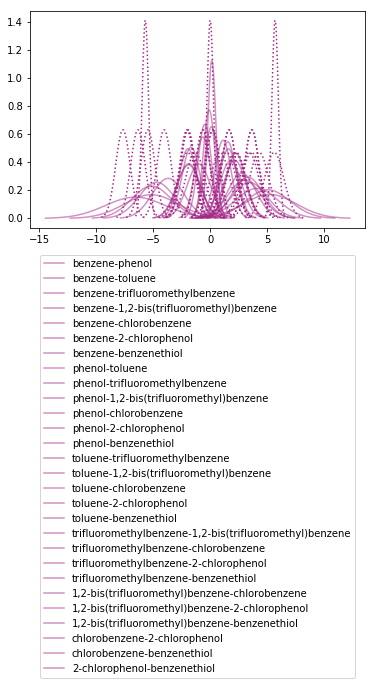

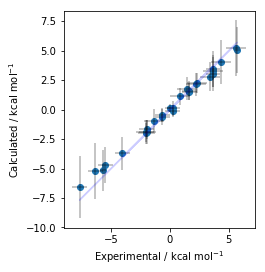

Step 500


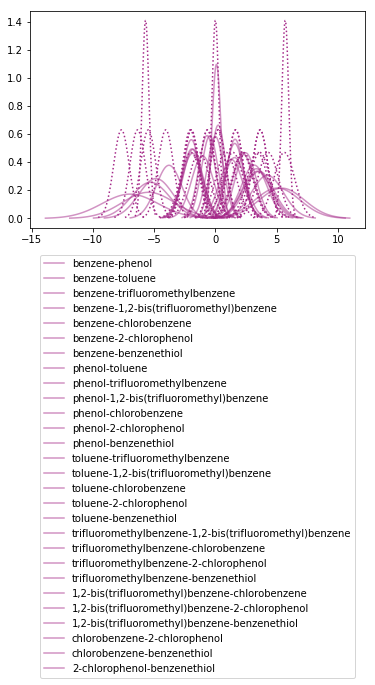

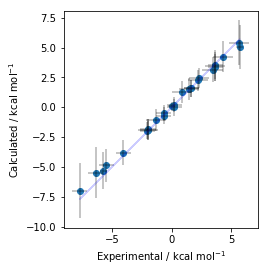

Step 750


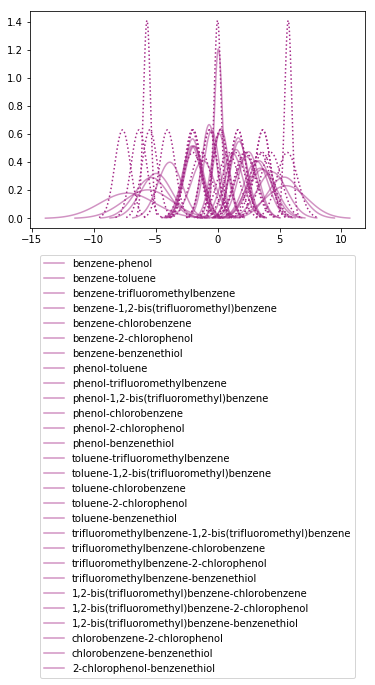

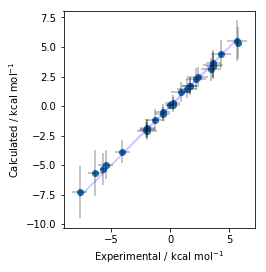

Step 1000


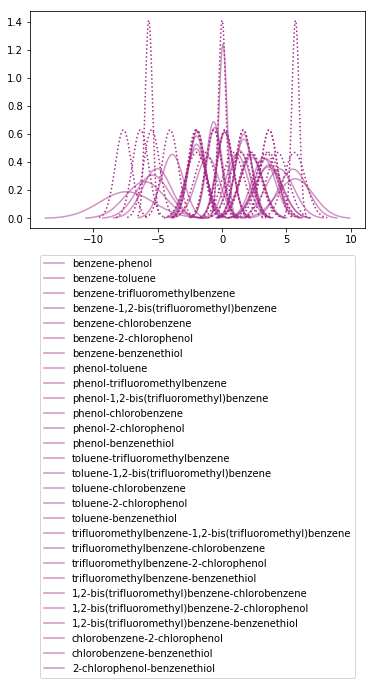

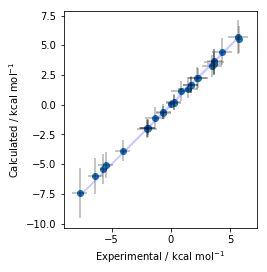

In [4]:
bandit_steps = 1000
for step in range(1,bandit_steps+1):
    # Boltzmann sampling 
    pick_bandit = choose.boltzmann_ranking(rel_bandits,5)
    reward = pull.Pull(pick_bandit)
#     print(pick_bandit.name)
    pick_bandit.update(reward)
    
    if step % 250 == 0:
        print('Step {}'.format(step))
        ax = plt.subplot(1, 1, 1)
        for band in rel_bandits:
            band.plot()
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.show()
        
        plotbanditsvsexperiment(rel_bandits)

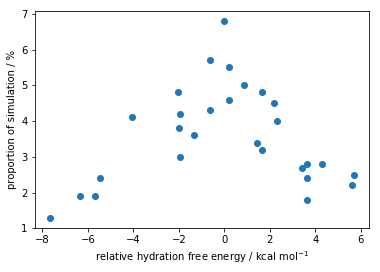

In [5]:
x = [band.fe for band in rel_bandits]
y = [(band.nsteps*100)/bandit_steps for band in rel_bandits]

plt.scatter(x,y)
plt.xlabel('relative hydration free energy / kcal mol$^{-1}$')
plt.ylabel('proportion of simulation / %')
plt.show()

### bandits on mappings instead of edges

In [37]:
def all_paths():


points = {1: [2,3],
          2: [1,3],
          3: [1,2]}


def find_paths(current_point, points):
    if len(points[current_point]) == 0:
        # End condition: have we found a complete path? Then yield
        if all(not v for v in points.values()):
            yield [current_point]
    else:
        for next_point in points[current_point]:
            new_points = deepcopy(points)
            new_points[current_point].remove(next_point)
            new_points[next_point].remove(current_point)
            paths = find_paths(next_point, new_points)
            for path in paths:
                yield [current_point] + path


def collect(points):
    results = []
    for first_point in points:
        result = find_paths(first_point, points)
        results.extend(list(result))
    return results

    print(collect(points))

In [115]:
edges_dict = {'+a':[1,2],'+b':[2,3],'+c':[3,1],'-a':[2,1],'-b':[3,2],'-c':[1,3]}
start = 1
end = 2

# TODO, expand this to include paths of N steps

two_step_paths = []

for comb in itertools.combinations(edges_dict,2):
    pathway = []
    if edges_dict[comb[0]][1] == edges_dict[comb[1]][0]: # check that the path is continuous
        if edges_dict[comb[0]][0] != edges_dict[comb[1]][1]: # check that the path isn't a mirror image
            two_step_paths.append([comb])

    
for x in two_step_paths:
    print(x)
    print([edges_dict[y] for y in x[0]])

[('+a', '+b')]
[[1, 2], [2, 3]]
[('+b', '+c')]
[[2, 3], [3, 1]]
[('-a', '-c')]
[[2, 1], [1, 3]]


In [25]:
ligands = []
# import drugbandit
with open('set_of_eight.smiles','r') as f:
    index = 0
    for line in f:
        if line[0] != '#':
            details = line.split(';')
            ligands.append([details[2], float(details[3]), float(details[4])])

index = 0
edges = []
# bandit.Perturbation()

for lig_a, lig_b in itertools.combinations(ligands[0:3],2):  # generating all edges
#    name, exp_fe, exp_error
    rel_name = lig_a[0]+'-'+lig_b[0]
    rel_fe = lig_a[1] - lig_b[1]
    rel_error = np.sqrt(lig_a[2]**2 + lig_b[2]**2)
    edges.append(bandit.Perturbation(rel_name,rel_fe,rel_error,index))
    index+=1

print(len(edges))
ligand_map = [random.sample(range(100), 2) for x in range(len(edges))]

bandit_steps = 10


for step in range(1,bandit_steps+1):
    # Boltzmann sampling 
    pick_edge = np.random.choice(edges) # this should be changed to pick in a bandit-like way
    pick_bandit = choose.boltzmann_ranking(pick_edge.bandits,0.1)
    reward = pull.Pull(pick_bandit)
    print(reward)
#     print(pick_bandit.name)
    pick_bandit.update(reward)
    pick_edge.update()
    if step % 2500 == 0:
        print('Step {}'.format(step))
        ax = plt.subplot(1, 1, 1)
        for edge in edges:
            edge.plot()
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.show()

3



1.7455534296655881
6.052651207446882
-8.917182652030023
0.1664958198206801
0.17095308056177935
11.33061948795799
1.1595845100530493
5.92781758347603
-5.475165956306694
5.477097302094451


CYCLE CLOSURE -- will only work for a set of 3 ligands currently


/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


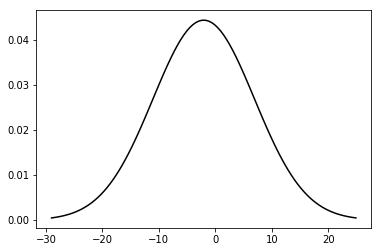

In [16]:
print('CYCLE CLOSURE -- will only work for a set of 3 ligands currently')
mu = np.mean([x.mu for x in edges])
# print(([x.mu for x in edges]))
sigma = np.linalg.norm([band.sigma for band in edges])

x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
y = mlab.normpdf(x, mu, sigma)
plt.plot(x, y,color='k')

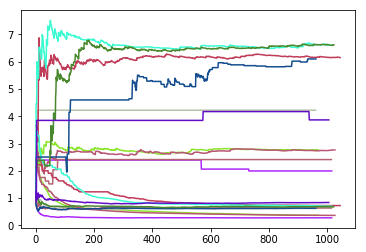

In [17]:
for edge in edges:
    for band in edge.bandits:
        plt.plot(band.sigma_history,color=edge.color)

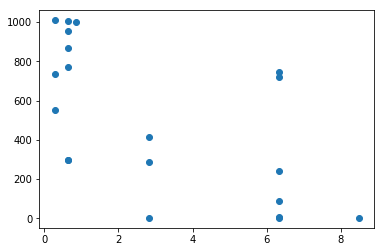

In [18]:
x = []
y = []
for edge in edges:
    for band in edge.bandits:
        x.append(band.error)
        y.append(band.nsteps)

plt.scatter(x,y)

/Users/brucemah/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/Users/brucemah/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/Users/brucemah/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/Users/brucemah/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes he

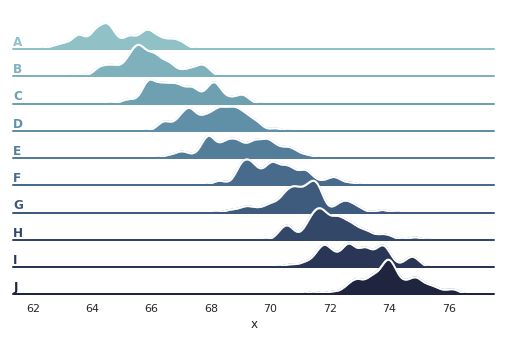

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)